
### **A Global Data-Driven Analysis of Life Expectancy: Patterns, Predictors, and Policy Implications**

## Objectives

**WHY:**

1.To uncover which social, economic, and healthcare factors most influence longevity across nations, enabling targeted policy interventions. 

2.To understand how life expectancy varies by country development status and quantify disparities. 

3.To assess the impact of public health measures (e.g., vaccination coverage) on life expectancy.

4.To support long-term planning in healthcare and demographics by projecting life expectancy trends. 

5.To assess whether life expectancy is normally distributed or exhibits skewness and outliers.  

6.To understand the influence of major health events or crises (e.g., disease outbreaks) on life expectancy. 

7.To spotlight countries that exceed expectations despite challenges, offering policy learning opportunities. 

**HOW:**

1.By training machine learning models (Random Forest, XGBoost) using predictors like Adult Mortality, HIV/AIDS, Schooling, GDP, and Health Expenditure. Extract feature importance scores and use SHAP values for interpretability.

2.By using the `Status` column to group countries (Developed vs Developing). Visualize differences using box plots, violin plots, and compute group summary statistics.

3.By Performing regression analyses relating life expectancy to variables such as Hepatitis B, Polio, and Diphtheria vaccination rates and health expenditure. Conduct subgroup analysis with defined thresholds.

4.By using a Random Forest regression model trained on historical data, including the "Year" variable, to predict future life expectancy. Time-based features are leveraged instead of full time series modeling due to limited per-country continuity.

5.By using histograms, Q-Q plots, and compute skewness and kurtosis statistics overall and within `Status` groups.

6.By using proxy variables—such as spikes in HIV/AIDS prevalence or adult mortality rates—to simulate shocks. Evaluate changes using model predictions or counterfactual scenarios.

7.Analyzing residuals from prediction models to identify over- and under-performers, then investigate contributing factors.


In [34]:
#Import Necessary Libraries
import pandas as pd      
import numpy as np      
import matplotlib.pyplot as plt 
import seaborn as sb    
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression     
from sklearn.metrics import r2_score, mean_absolute_error 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer 
import plotly.express as px  
from mpl_toolkits.mplot3d import Axes3D
  


## **Data Loading, Cleaning & Preparation**


In [35]:
# Load the dataset
df = pd.read_csv('Life_Expectancy_Data.csv')  

df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,...,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,...,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,...,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,...,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,...,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [36]:
df = pd.read_csv("Life_Expectancy_Data.csv")
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Year                             1649 non-null   int64  
 2   Status                           1649 non-null   object 
 3   Life expectancy                  1649 non-null   float64
 4   Adult Mortality                  1649 non-null   int64  
 5   infant deaths                    1649 non-null   int64  
 6   Alcohol                          1649 non-null   float64
 7   percentage expenditure           1649 non-null   float64
 8   Hepatitis B                      1649 non-null   int64  
 9   Measles                          1649 non-null   int64  
 10   BMI                             1649 non-null   float64
 11  under-five deaths                1649 non-null   int64  
 12  Polio               

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1.649000e+03,1649.000000,1649.000000,1649.000000,1649.000000
mean,2007.840509,69.302304,168.215282,32.553062,4.533196,698.973558,79.217708,2224.494239,38.128623,44.220133,83.564585,5.955925,84.155246,1.983869,5566.031887,1.465363e+07,4.850637,4.907762,0.631551,12.119891
std,4.087711,8.796834,125.310417,120.847190,4.029189,1759.229336,25.604664,10085.802019,19.754249,162.897999,22.450557,2.299385,21.579193,6.032360,11475.900117,7.046039e+07,4.599228,4.653757,0.183089,2.795388
min,2000.000000,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,2.000000,0.000000,3.000000,0.740000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,2005.000000,64.400000,77.000000,1.000000,0.810000,37.438577,74.000000,0.000000,19.500000,1.000000,81.000000,4.410000,82.000000,0.100000,462.149650,1.918970e+05,1.600000,1.700000,0.509000,10.300000
50%,2008.000000,71.700000,148.000000,3.000000,3.790000,145.102253,89.000000,15.000000,43.700000,4.000000,93.000000,5.840000,92.000000,0.100000,1592.572182,1.419631e+06,3.000000,3.200000,0.673000,12.300000
75%,2011.000000,75.000000,227.000000,22.000000,7.340000,509.389994,96.000000,373.000000,55.800000,29.000000,97.000000,7.470000,97.000000,0.700000,4718.512910,7.658972e+06,7.100000,7.100000,0.751000,14.000000
max,2015.000000,89.000000,723.000000,1600.000000,17.870000,18961.348600,99.000000,131441.000000,77.100000,2100.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.293859e+09,27.200000,28.200000,0.936000,20.700000


In [37]:
df.shape 

(1649, 22)

In [38]:
df['Country'] = df['Country'].astype('category')
df['Status'] = df['Status'].astype('category')

print("Updated Data Types:")
print(df.dtypes[['Country', 'Status']])


Updated Data Types:
Country    category
Status     category
dtype: object


In [39]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

In [40]:
#Checking if there are any duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [41]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_table = pd.DataFrame({
    'Missing Values': missing_values,
    '% Missing': missing_percent.round(2)
}).sort_values(by='Missing Values', ascending=False)

print(" Missing Values Summary:")
display(missing_table)

 Missing Values Summary:


,Missing Values,% Missing
Country,0,0.0
Year,0,0.0
Status,0,0.0
Life expectancy,0,0.0
Adult Mortality,0,0.0
infant deaths,0,0.0
Alcohol,0,0.0
percentage expenditure,0,0.0
Hepatitis B,0,0.0
Measles,0,0.0


In [42]:
# Checking for skewness in numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
skewness = df[numerical_cols].skew()
print("\nSkewness of numerical columns:")
print(skewness)


Skewness of numerical columns:
Year                               -0.200171
Life expectancy                    -0.628758
Adult Mortality                     1.276429
infant deaths                       8.477369
Alcohol                             0.662518
percentage expenditure              4.980574
Hepatitis B                        -1.793377
Measles                             7.957838
BMI                                -0.233601
under-five deaths                   8.340863
Polio                              -2.360177
Total expenditure                   0.213362
Diphtheria                         -2.487492
HIV/AIDS                            4.974176
GDP                                 4.517297
Population                         14.186299
thinness  1-19 years                1.821074
thinness 5-9 years                  1.866980
Income composition of resources    -1.155244
Schooling                          -0.128164
dtype: float64


In [43]:
high_skew = skewness[abs(skewness) >= 5].index
for col in high_skew:
    df[col] = np.log1p(df[col])
    print(f"Applied log transformation to {col}")   
    
skewness = df[numerical_cols].skew()
print("\nSkewness after transformation:")
print(skewness)

Applied log transformation to infant deaths
Applied log transformation to Measles
Applied log transformation to under-five deaths
Applied log transformation to Population

Skewness after transformation:
Year                              -0.200171
Life expectancy                   -0.628758
Adult Mortality                    1.276429
infant deaths                      0.718501
Alcohol                            0.662518
percentage expenditure             4.980574
Hepatitis B                       -1.793377
Measles                            0.560259
BMI                               -0.233601
under-five deaths                  0.666207
Polio                             -2.360177
Total expenditure                  0.213362
Diphtheria                        -2.487492
HIV/AIDS                           4.974176
GDP                                4.517297
Population                        -0.544872
thinness  1-19 years               1.821074
thinness 5-9 years                 1.866980
Incom

## **objective 1 : Key Drivers of Life Expectancy**

In [44]:
# Correlation matrix with target variable
correlation = df.corr(numeric_only=True)['Life expectancy'].sort_values(ascending=False)
print("Correlation with Life Expectancy:\n")
print(correlation)


Correlation with Life Expectancy:

Life expectancy                    1.000000
Schooling                          0.727630
Income composition of resources    0.721083
BMI                                0.542042
GDP                                0.441322
percentage expenditure             0.409631
Alcohol                            0.402718
Diphtheria                         0.341331
Polio                              0.327294
Hepatitis B                        0.199935
Total expenditure                  0.174718
Year                               0.050771
Population                        -0.100433
Measles                           -0.253603
thinness 5-9 years                -0.457508
thinness  1-19 years              -0.457838
infant deaths                     -0.517603
under-five deaths                 -0.546867
HIV/AIDS                          -0.592236
Adult Mortality                   -0.702523
Name: Life expectancy, dtype: float64


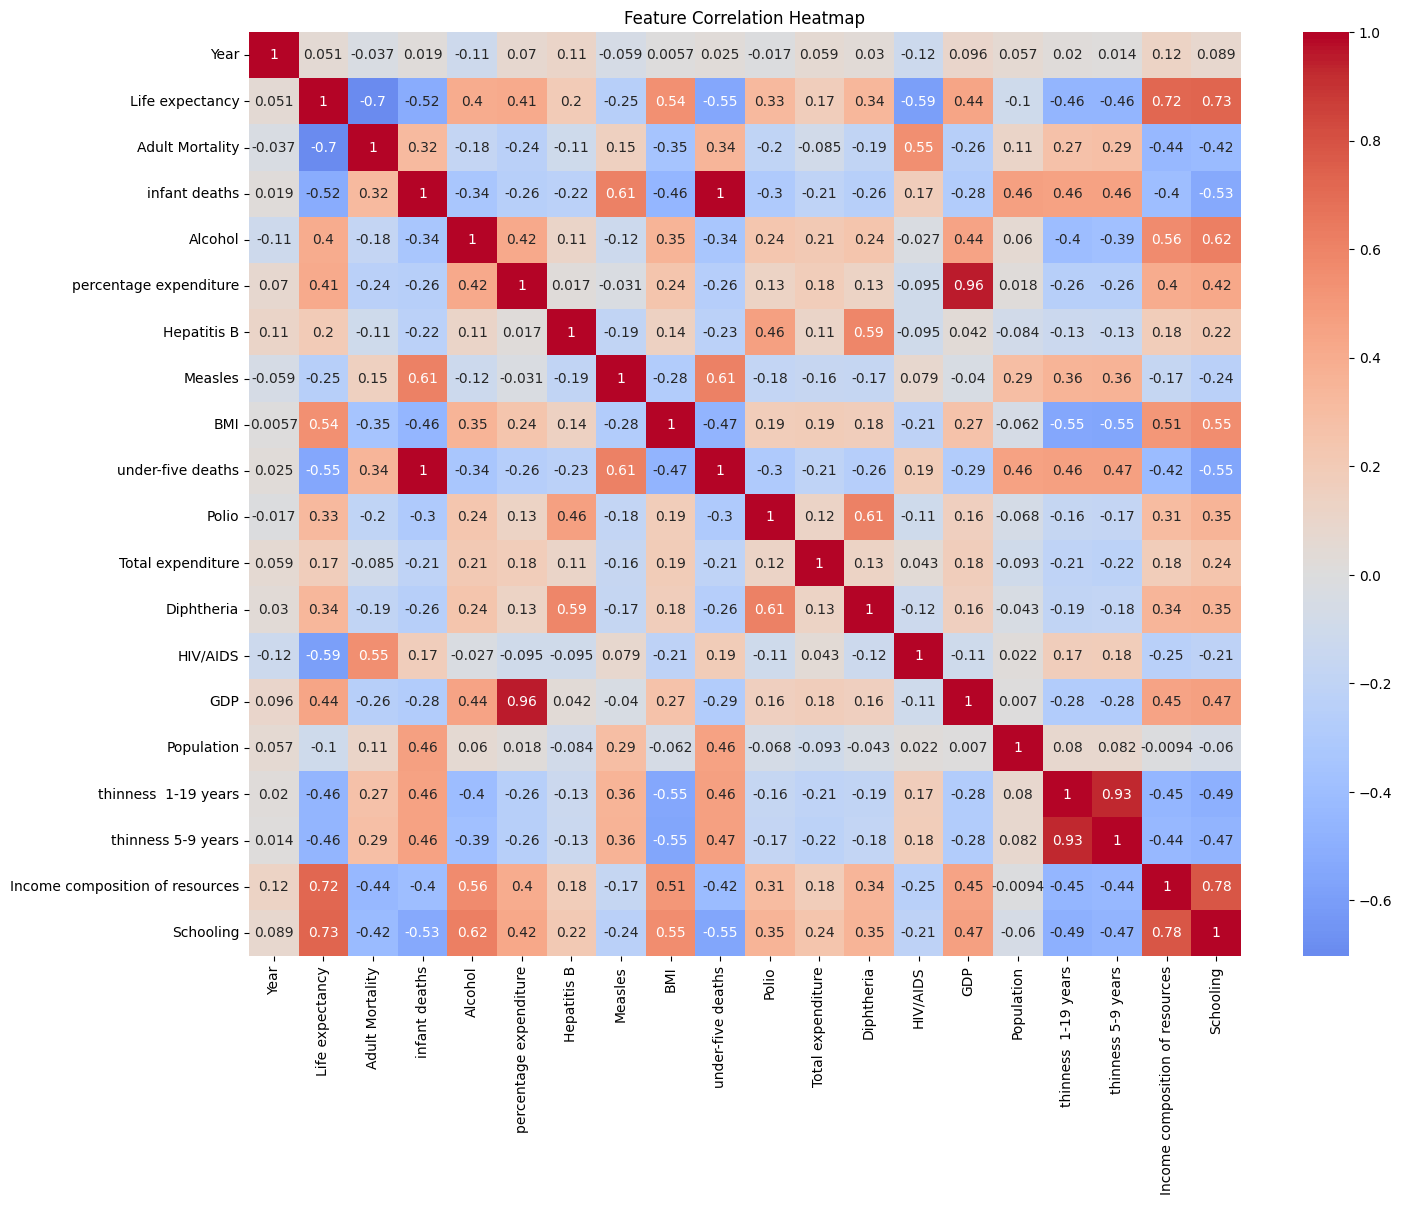

In [45]:
plt.figure(figsize=(16, 12))
sb.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [46]:
# Remove Highly Correlated Features to avoid redundancy (|correlation|>0.8)
# Getting rid of under-five deaths column since it is perfectly positively correlated with infant deaths hence a redundant feature
df.drop(columns=['under-five deaths'], inplace=True)
df.shape

# Getting rid of thinness 5-9 since it is very highly positively correlated with thinness 1-19 years hence a redundant feature
df.drop(columns=['thinness 5-9 years'], inplace=True)

# Gettting rid of percent expenditure since it is highly negatively correlated with GDP
df.drop(columns=['percentage expenditure'], inplace=True)

In [47]:
#GDP per Capita
df['GDP_per_capita'] = df['GDP'] / df['Population']
df['GDP_per_capita'] = df['GDP_per_capita'].fillna(df['GDP_per_capita'].mean())

#Vaccination Composite Feature
df['Vaccination'] = df[['Hepatitis B', 'Measles', 'Polio', 'Diphtheria']].mean(axis=1)

#BMI Categories
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI Category'] = pd.cut(df['BMI'], bins=bins, labels=labels)

#Total Expenditure per Capita
df['Total_expenditure_per_capita'] = df['Total expenditure'] / df['Population']



df[['GDP_per_capita','Vaccination','BMI Category','Total_expenditure_per_capita']].head()



,GDP_per_capita,Vaccination,BMI Category,Total_expenditure_per_capita
0,33.705789,35.762964,Normal,0.470749
1,48.245732,47.050127,Normal,0.644120
2,36.574499,49.016527,Underweight,0.470682
3,44.300606,52.233270,Underweight,0.563379
4,4.262252,53.002756,Underweight,0.527941


In [48]:
# One-hot encode 'BMI Category', drop the first category to avoid multicollinearity
df = pd.get_dummies(df, columns=['BMI Category'], drop_first=True)


In [49]:
df['Status_original'] = df['Status']  # save original first
df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1}).astype(int)


In [50]:
df[['GDP_per_capita', 'Vaccination', 'Total_expenditure_per_capita', 'Life expectancy']].corr()


,GDP_per_capita,Vaccination,Total_expenditure_per_capita,Life expectancy
GDP_per_capita,1.000000,0.137467,0.198158,0.425759
Vaccination,0.137467,1.000000,0.127386,0.329484
Total_expenditure_per_capita,0.198158,0.127386,1.000000,0.193366
Life expectancy,0.425759,0.329484,0.193366,1.000000


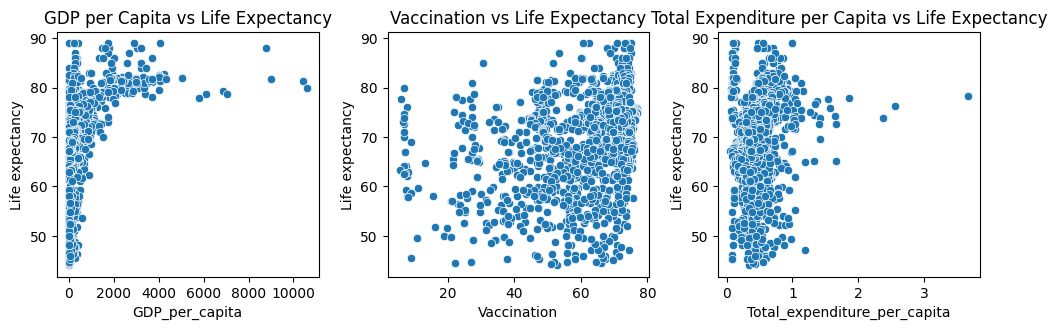

In [51]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
sb.scatterplot(x='GDP_per_capita', y='Life expectancy', data=df)
plt.title('GDP per Capita vs Life Expectancy')


plt.subplot(2, 3, 2)
sb.scatterplot(x='Vaccination', y='Life expectancy', data=df)
plt.title('Vaccination vs Life Expectancy')


plt.subplot(2, 3, 3)
sb.scatterplot(x='Total_expenditure_per_capita', y='Life expectancy', data=df)
plt.title('Total Expenditure per Capita vs Life Expectancy')
plt.tight_layout()
plt.show()



In [52]:

from sklearn.metrics import mean_squared_error, r2_score

baseline_features = [
    'Status',
    'Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'Measles', 'BMI', 'Polio',
    'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
    'Income composition of resources', 'Schooling'
]

engineered_features = [
    'GDP_per_capita', 'Vaccination', 'Total_expenditure_per_capita',
    'BMI Category_Normal', 'BMI Category_Overweight', 'BMI Category_Obese'
]

target = 'Life expectancy'


# Prepare datasets
X_baseline = df[baseline_features]
X_enhanced = df[baseline_features + engineered_features]
y = df[target]



# 3. Train-test split (same seed)
Xb_train, Xb_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.2, random_state=42)
Xe_train, Xe_test, _, _ = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

# 4. Initialize models
rf_baseline = RandomForestRegressor(random_state=42)
rf_enhanced = RandomForestRegressor(random_state=42)

# 5. Train models
rf_baseline.fit(Xb_train, y_train)
rf_enhanced.fit(Xe_train, y_train)

# 6. Predict and evaluate
y_pred_baseline = rf_baseline.predict(Xb_test)
y_pred_enhanced = rf_enhanced.predict(Xe_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
rmse_enhanced = np.sqrt(mean_squared_error(y_test, y_pred_enhanced))

r2_baseline = r2_score(y_test, y_pred_baseline)
r2_enhanced = r2_score(y_test, y_pred_enhanced)

print(f'Baseline RMSE: {rmse_baseline:.3f}, R²: {r2_baseline:.3f}')
print(f'Enhanced RMSE: {rmse_enhanced:.3f}, R²: {r2_enhanced:.3f}')



Baseline RMSE: 1.884, R²: 0.950
Enhanced RMSE: 1.920, R²: 0.948


In [53]:

# 1. Feature definitions
baseline_features = [
    'Status',
    'Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'Measles', 'BMI', 'Polio',
    'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
    'Income composition of resources', 'Schooling'
]

engineered_features = [
    'GDP_per_capita', 'Vaccination', 'Total_expenditure_per_capita',
    'BMI Category_Normal', 'BMI Category_Overweight', 'BMI Category_Obese'
]

target = 'Life expectancy'

# 2. Prepare data
X_baseline = df[baseline_features]
X_enhanced = df[baseline_features + engineered_features]
y = df[target]

# 3. Train-test split
Xb_train, Xb_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.2, random_state=42)
Xe_train, Xe_test, _, _ = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

# 4. Initialize XGBoost models
xgb_baseline = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_enhanced = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

# 5. Train models
xgb_baseline.fit(Xb_train, y_train)
xgb_enhanced.fit(Xe_train, y_train)

# 6. Predict and evaluate
y_pred_baseline = xgb_baseline.predict(Xb_test)
y_pred_enhanced = xgb_enhanced.predict(Xe_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
rmse_enhanced = np.sqrt(mean_squared_error(y_test, y_pred_enhanced))

r2_baseline = r2_score(y_test, y_pred_baseline)
r2_enhanced = r2_score(y_test, y_pred_enhanced)

print(f'XGBoost Baseline RMSE: {rmse_baseline:.3f}, R²: {r2_baseline:.3f}')
print(f'XGBoost Enhanced RMSE: {rmse_enhanced:.3f}, R²: {r2_enhanced:.3f}')


XGBoost Baseline RMSE: 2.024, R²: 0.942
XGBoost Enhanced RMSE: 2.087, R²: 0.939


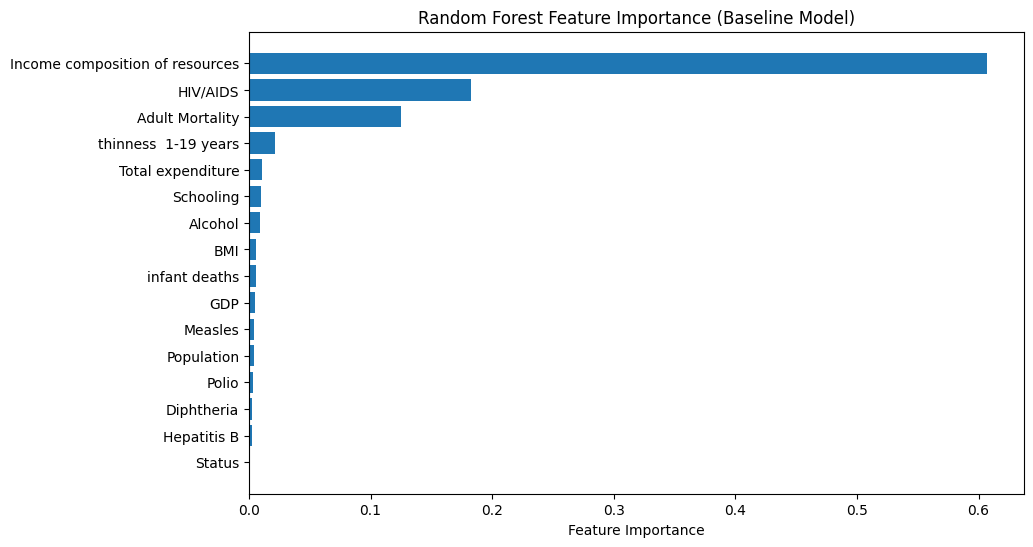

In [54]:
importances = rf_baseline.feature_importances_
feature_names = X_baseline.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Baseline Model)')
plt.gca().invert_yaxis()
plt.show()


 98%|===================| 323/330 [00:35<00:00]        

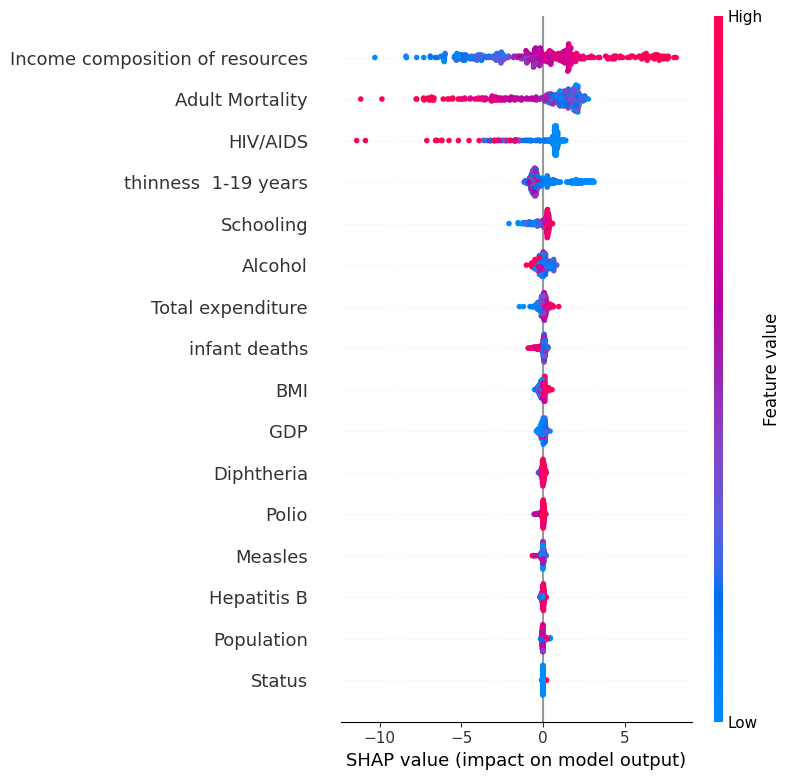

In [55]:

import shap
# Create the SHAP explainer
explainer = shap.Explainer(rf_baseline, Xb_test)

#Compute SHAP values
shap_values = explainer(Xb_test)

# Visualize feature importance (summary plot)
shap.summary_plot(shap_values, Xb_test)


**While correlation analysis highlighted Schooling, Income Composition of Resources, and Adult Mortality as key factors, the Random Forest model identified Income Composition,Adult Mortality , and HIV/AIDS prevalence as the strongest predictors. This suggests that economic wellbeing and disease burden—particularly HIV/AIDS—are the most influential drivers of life expectancy in this dataset. Schooling likely contributes indirectly through its impact on income and resources**

## ***Inequality in Life Expectancy by Development Status***

In [56]:
# Check unique values in Status
print(df['Status'].unique())

# Group data by 'Status' (Developed vs Developing)
developed = df[df['Status_original'] == 'Developed']['Life expectancy']
developing = df[df['Status_original'] == 'Developing']['Life expectancy']



[0 1]


In [57]:
print("Developed countries life expectancy stats:")
print(developed.describe())

print("\nDeveloping countries life expectancy stats:")
print(developing.describe())


Developed countries life expectancy stats:
count    242.000000
mean      78.691736
std        4.273485
min       69.900000
25%       75.550000
50%       78.950000
75%       81.400000
max       89.000000
Name: Life expectancy, dtype: float64

Developing countries life expectancy stats:
count    1407.000000
mean       67.687349
std         8.353983
min        44.000000
25%        62.800000
50%        69.200000
75%        73.800000
max        89.000000
Name: Life expectancy, dtype: float64


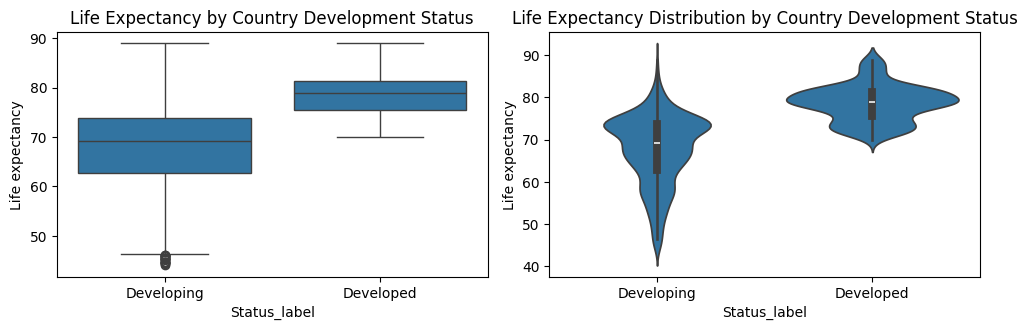

In [58]:
df['Status_label'] = df['Status'].map({0: 'Developing', 1: 'Developed'})

plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
sb.boxplot(x='Status_label', y='Life expectancy', data=df)
plt.title('Life Expectancy by Country Development Status')

plt.subplot(2, 2, 2)

sb.violinplot(x='Status_label', y='Life expectancy', data=df)
plt.title('Life Expectancy Distribution by Country Development Status')
plt.tight_layout()
plt.show()


**Developed countries exhibit higher and more consistent life expectancy compared to developing countries, highlighting clear disparities in health outcomes. This emphasizes the need for targeted interventions to address systemic challenges in developing nations.**

## ***Role of Specific Health Interventions*** 


Regression summary for Hepatitis B:
                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     68.58
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           2.49e-16
Time:                        16:44:19   Log-Likelihood:                -5891.3
No. Observations:                1649   AIC:                         1.179e+04
Df Residuals:                    1647   BIC:                         1.180e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        

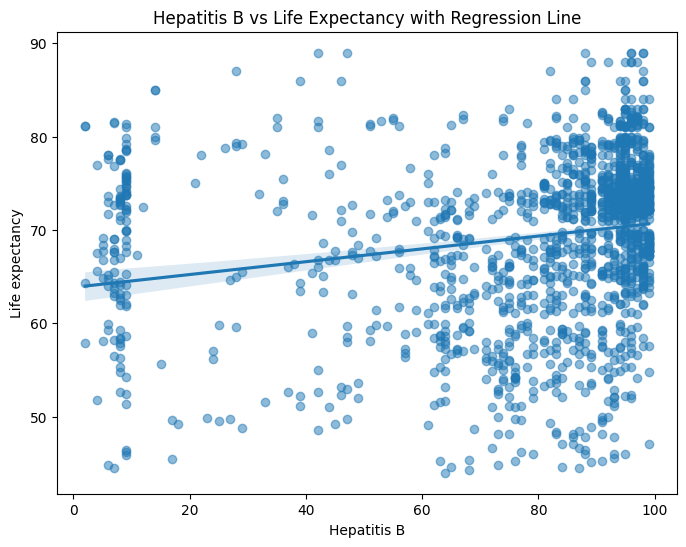

Regression summary for Polio:
                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     197.6
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           1.79e-42
Time:                        16:44:21   Log-Likelihood:                -5831.5
No. Observations:                1649   AIC:                         1.167e+04
Df Residuals:                    1647   BIC:                         1.168e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.5856

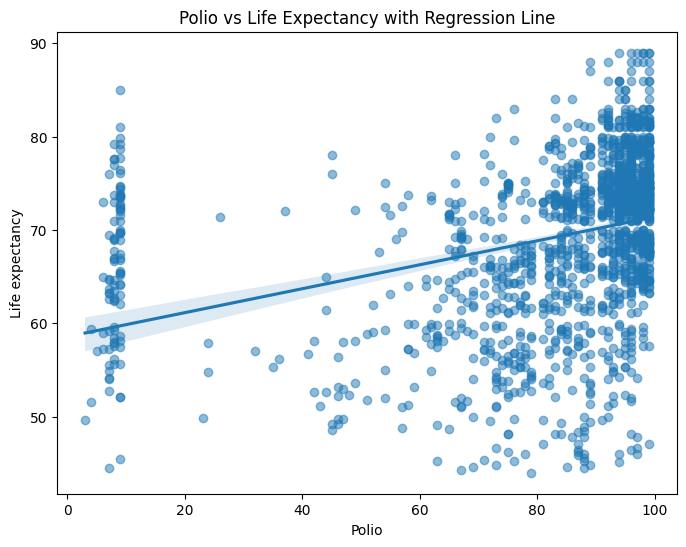

Regression summary for Diphtheria:
                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     217.2
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           2.86e-46
Time:                        16:44:23   Log-Likelihood:                -5822.8
No. Observations:                1649   AIC:                         1.165e+04
Df Residuals:                    1647   BIC:                         1.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57

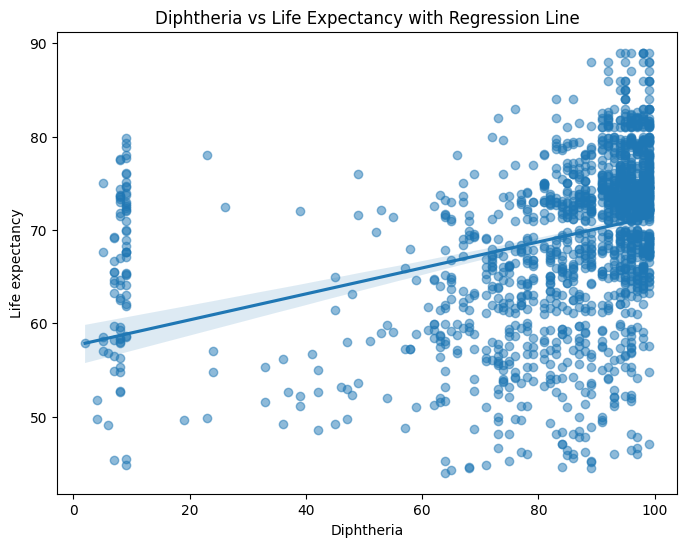

Regression summary for Total expenditure:
                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     51.86
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           9.03e-13
Time:                        16:44:24   Log-Likelihood:                -5899.3
No. Observations:                1649   AIC:                         1.180e+04
Df Residuals:                    1647   BIC:                         1.181e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

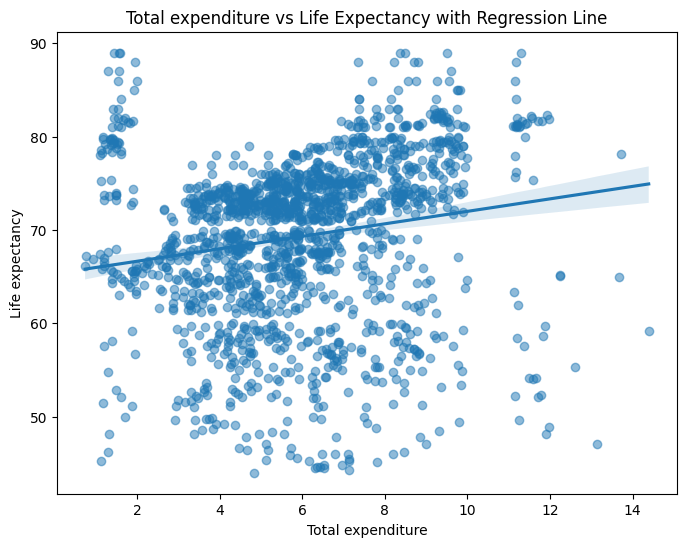

Multiple regression summary:
                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     75.66
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           6.17e-59
Time:                        16:44:25   Log-Likelihood:                -5785.6
No. Observations:                1649   AIC:                         1.158e+04
Df Residuals:                    1644   BIC:                         1.161e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

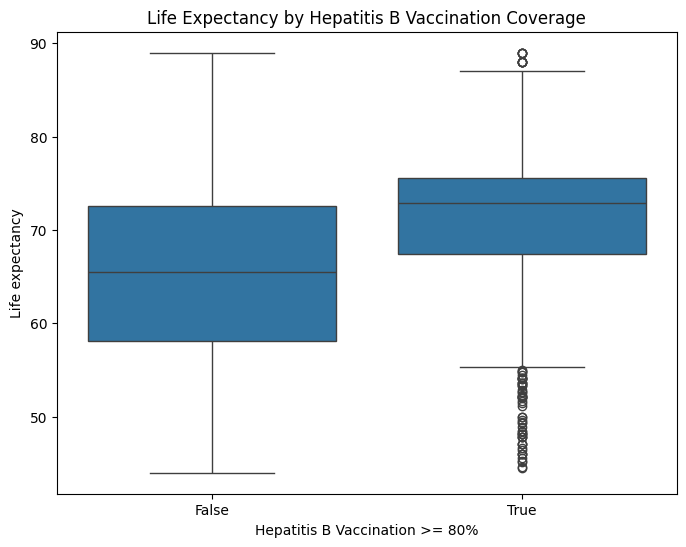

In [59]:
import statsmodels.api as sm


# Variables of interest
health_vars = ['Hepatitis B', 'Polio', 'Diphtheria', 'Total expenditure']
target = 'Life expectancy'

# Simple linear regression for each health variable
for var in health_vars:
    X = df[[var]].copy()
    X = sm.add_constant(X)  # adds intercept term
    y = df[target]
    
    model = sm.OLS(y, X).fit()
    print(f"Regression summary for {var}:\n", model.summary())

    # Scatter plot with regression line
    plt.figure(figsize=(8,6))
    sb.regplot(x=var, y=target, data=df, scatter_kws={'alpha':0.5})
    plt.title(f"{var} vs Life Expectancy with Regression Line")
    plt.show()

# Multiple regression including all health variables
X_multi = df[health_vars]
X_multi = sm.add_constant(X_multi)
y = df[target]

multi_model = sm.OLS(y, X_multi).fit()
print("Multiple regression summary:\n", multi_model.summary())

# Optional: subgroup analysis by vaccination coverage threshold (e.g., Hep B >= 80%)
threshold = 80
high_vax = df[df['Hepatitis B'] >= threshold]
low_vax = df[df['Hepatitis B'] < threshold]

print(f"Mean Life Expectancy for High Hepatitis B vaccination (>= {threshold}%): {high_vax[target].mean():.2f}")
print(f"Mean Life Expectancy for Low Hepatitis B vaccination (< {threshold}%): {low_vax[target].mean():.2f}")

# Boxplot for subgroup comparison
plt.figure(figsize=(8,6))
sb.boxplot(x=df['Hepatitis B'] >= threshold, y=df[target])
plt.xlabel(f'Hepatitis B Vaccination >= {threshold}%')
plt.title('Life Expectancy by Hepatitis B Vaccination Coverage')
plt.show()


**The analysis demonstrates that vaccination coverage for Polio and Diphtheria, along with health expenditure, have a significant positive impact on life expectancy. While Hepatitis B vaccination showed a positive correlation individually, its effect was less clear when accounting for other factors. Countries with higher Hepatitis B vaccination rates (≥80%) also experience notably higher average life expectancy. These findings underscore the critical role of public health interventions, especially immunization programs and health investment, in improving longevity and population health outcomes.**

## ***Model and Forecast Future Life Expectancy***

In [60]:
# Example: Split data into training (<= 2010) and testing (> 2010)
train_df = df[df['Year'] <= 2010]
test_df = df[df['Year'] > 2010]

features = baseline_features + engineered_features + ['Year']
target = 'Life expectancy'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Initialize and train model (Random Forest example)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Forecast
y_pred = rf.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Forecast RMSE: {rmse:.3f}, R²: {r2:.3f}")


Forecast RMSE: 2.463, R²: 0.917



**Given the  strong performance, the model can be considered reliable for forecasting future life expectancy, assuming that future data trends remain consistent with historical patterns**

## ***Distributional Analysis of Life Expectancy***

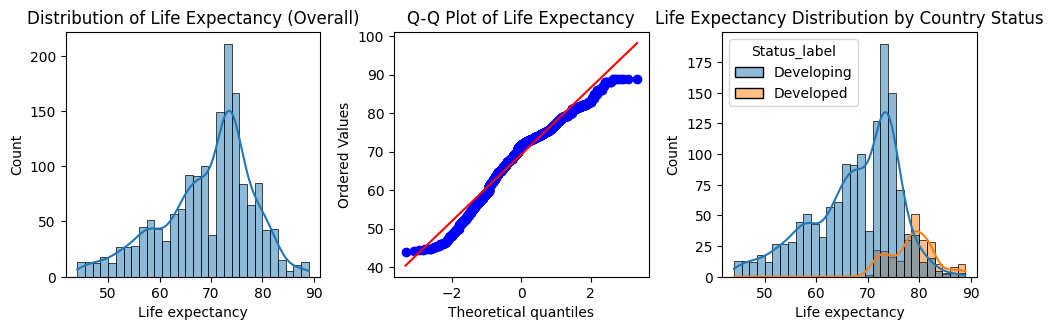

Skewness: -0.6281859909810332
Kurtosis: 0.03656198417517631


In [61]:
from scipy.stats import skew, kurtosis
import scipy.stats as stats


# Histogram

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
sb.histplot(df['Life expectancy'], kde=True, bins=30)
plt.title("Distribution of Life Expectancy (Overall)")


# Q-Q Plot
plt.subplot(2, 3, 2)
stats.probplot(df['Life expectancy'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Life Expectancy")


# By Development Status
plt.subplot(2, 3, 3)
sb.histplot(data=df, x='Life expectancy', hue='Status_label', kde=True, bins=30)
plt.title("Life Expectancy Distribution by Country Status")
plt.tight_layout()
plt.show()

# Skewness and Kurtosis
print("Skewness:", skew(df['Life expectancy']))
print("Kurtosis:", kurtosis(df['Life expectancy']))






**Life expectancy exhibits a slight left skew and near-normal kurtosis, reflecting a mild concentration of higher values. Q-Q plots reveal moderate deviations from normality, primarily in the lower tail. When split by development status, developed countries have higher and more consistent life expectancy, while developing countries display greater variability and outliers, reflecting health inequalities and diverse country-specific challenges.**

## ***Impact of Shocks on Life Expectancy***


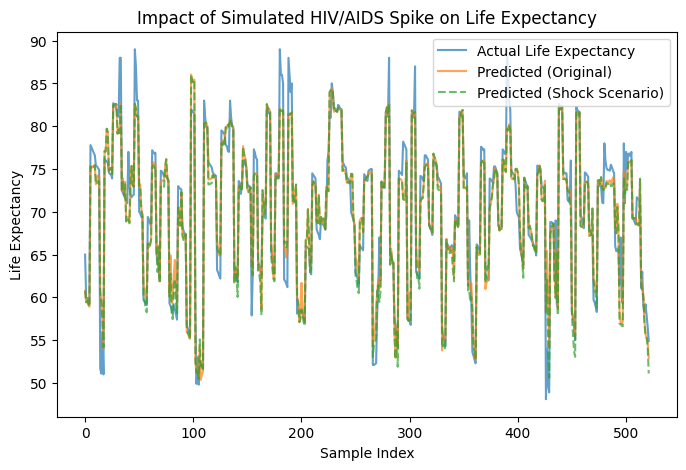

 Average predicted drop in life expectancy due to HIV/AIDS shock: 0.25 years


In [62]:

shock_df = X_test.copy()

# Introduce a shock: increase HIV/AIDS rate by 50%
shock_df['HIV/AIDS'] = shock_df['HIV/AIDS'] * 1.5


y_pred_shock = rf.predict(shock_df)

# Compare predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual Life Expectancy', alpha=0.7)
plt.plot(y_pred, label='Predicted (Original)', alpha=0.7)
plt.plot(y_pred_shock, label='Predicted (Shock Scenario)', alpha=0.7, linestyle='--')
plt.title('Impact of Simulated HIV/AIDS Spike on Life Expectancy')
plt.ylabel('Life Expectancy')
plt.xlabel('Sample Index')
plt.legend()
plt.show()

# Calculate average drop in life expectancy due to the shock
impact = (y_pred - y_pred_shock).mean()
print(f" Average predicted drop in life expectancy due to HIV/AIDS shock: {impact:.2f} years")


**Simulating a health crisis—by increasing HIV/AIDS prevalence by 50%—resulted in an average predicted drop of 0.25 years in life expectancy. This demonstrates that sudden disease outbreaks can lead to measurable setbacks in population health. It highlights the importance of resilient public health systems and early intervention strategies to mitigate the impact of such shocks**

## ***Identify Outlier Countries (“Positive Deviants”)***

In [63]:
# Use the best-performing model (e.g., your Random Forest or XGBoost trained on full data)
df['Predicted Life Expectancy'] = rf.predict(df[features])
df['Residual'] = df['Life expectancy'] - df['Predicted Life Expectancy']


In [64]:
# Set thresholds (e.g., top 5% and bottom 5% of residuals)
threshold_high = df['Residual'].quantile(0.95)
threshold_low = df['Residual'].quantile(0.05)

# Positive Deviants: actual > predicted
positive_deviants = df[df['Residual'] >= threshold_high]

# Negative Deviants: actual < predicted
negative_deviants = df[df['Residual'] <= threshold_low]

print(" Positive Deviants:")
print(positive_deviants[['Country', 'Year', 'Life expectancy', 'Predicted Life Expectancy', 'Residual']])

print("\n Negative Deviants:")
print(negative_deviants[['Country', 'Year', 'Life expectancy', 'Predicted Life Expectancy', 'Residual']])


 Positive Deviants:
          Country  Year  Life expectancy  Predicted Life Expectancy  Residual
0     Afghanistan  2015             65.0                     60.777     4.223
16        Albania  2015             77.8                     75.352     2.448
17        Albania  2014             77.5                     75.117     2.383
32        Algeria  2014             75.4                     73.235     2.165
93        Austria  2014             81.4                     79.126     2.274
...           ...   ...              ...                        ...       ...
1610      Vanuatu  2013             71.6                     68.514     3.086
1611      Vanuatu  2012             71.4                     68.396     3.004
1614      Vanuatu  2009             78.0                     75.844     2.156
1634     Zimbabwe  2014             59.2                     55.773     3.427
1635     Zimbabwe  2013             58.0                     55.301     2.699

[83 rows x 5 columns]

 Negative Deviants:


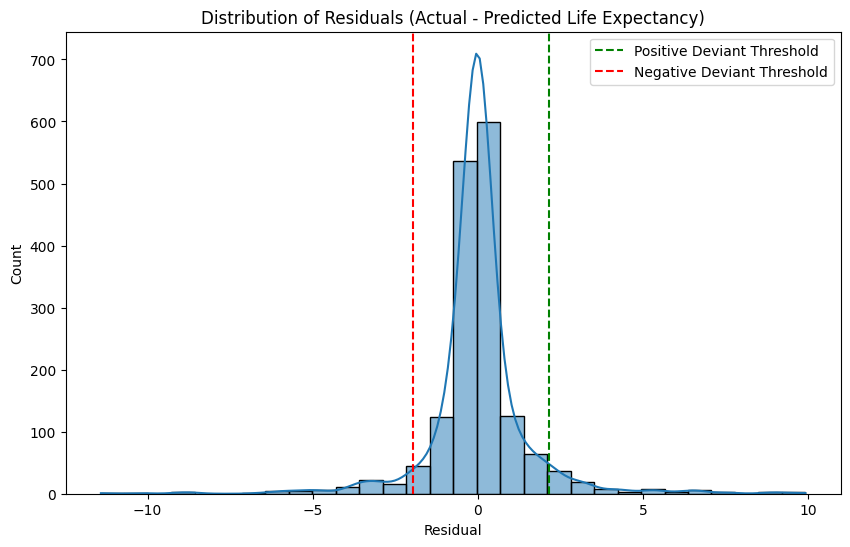

In [65]:


plt.figure(figsize=(10, 6))
sb.histplot(df['Residual'], bins=30, kde=True)
plt.axvline(threshold_high, color='green', linestyle='--', label='Positive Deviant Threshold')
plt.axvline(threshold_low, color='red', linestyle='--', label='Negative Deviant Threshold')
plt.title('Distribution of Residuals (Actual - Predicted Life Expectancy)')
plt.xlabel('Residual')
plt.legend()
plt.show()


**Analyzing residuals from the life expectancy model revealed clear outliers. Countries like Afghanistan, Vanuatu, and Zimbabwe exceeded expectations, indicating possible hidden strengths such as effective local health initiatives or cultural resilience. In contrast, Angola, Argentina, and Turkmenistan underperformed, pointing to unmodeled challenges like political instability or recent health crises.**

**These findings underscore the value of residual analysis in spotlighting countries that merit deeper investigation—whether to learn from unexpected success or understand underperformance.**

## **Model Evaluation and Cross-Validation**

In [66]:

# 1. Define feature sets and target
baseline_features = [
    'Status', 'Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'Measles', 'BMI',
    'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
    'thinness  1-19 years', 'Income composition of resources', 'Schooling'
]

engineered_features = [
    'GDP_per_capita', 'Vaccination', 'Total_expenditure_per_capita',
    'BMI Category_Normal', 'BMI Category_Overweight', 'BMI Category_Obese'
]

target = 'Life expectancy'
X_baseline = df[baseline_features]
X_enhanced = df[baseline_features + engineered_features]
y = df[target]

# 2. Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


# 3. Define all models
models = {
    "Random Forest (Baseline)": (RandomForestRegressor(random_state=42), X_baseline),
    "Random Forest (Enhanced)": (RandomForestRegressor(random_state=42), X_enhanced),
    "XGBoost (Baseline)": (XGBRegressor(random_state=42, verbosity=0), X_baseline),
    "XGBoost (Enhanced)": (XGBRegressor(random_state=42, verbosity=0), X_enhanced)
}

# 4. Evaluate models
results = []

for name, (model, X) in models.items():
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    
    results.append({
        'Model': name,
        'R² Mean': np.mean(r2_scores),
        'R² Std': np.std(r2_scores),
        'RMSE Mean': np.mean(rmse_scores),
        'RMSE Std': np.std(rmse_scores)
    })

# 5. Show results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R² Mean', ascending=False)
print(results_df)


                      Model   R² Mean    R² Std  RMSE Mean  RMSE Std
0  Random Forest (Baseline)  0.954600  0.008484  -1.854939  0.150073
1  Random Forest (Enhanced)  0.953208  0.008223  -1.884153  0.131849
2        XGBoost (Baseline)  0.949259  0.009195  -1.962117  0.152782
3        XGBoost (Enhanced)  0.948791  0.009546  -1.969414  0.142806
